# <span style='font-family:"Times New Roman"'> <span styel=''>**WHOLE GENOME DOUBLING ANALYSIS**

*Emile Cohen*
    
 *May 2020*

**Goal:** In this notebook, we discover the non-WGD cohort, its main metrics, through the master.

---

In [101]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [102]:
# Load the master
master_no_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_no_wgd.head()

,Sample_Id,Tumor_Id,Patient_Id,Cancer_Type,Cancer_Type_Detailed,Patient_Current_Age,Sample_Type,purity,ploidy,Overall_Survival_Months,Overall_Survival_Status,MSI_Score,MSI_Type,TMB_Score,tp53_key_1,tp53_vc_1,tp53_ccf_1,tp53_vaf_1,tp53_HGVSp_1,tp53_spot_1,tp53_key_2,tp53_vc_2,tp53_ccf_2,tp53_vaf_2,tp53_HGVSp_2,tp53_spot_2,tp53_key_3,tp53_vc_3,tp53_ccf_3,tp53_vaf_3,tp53_HGVSp_3,tp53_spot_3,tp53_key_4,tp53_vc_4,tp53_ccf_4,tp53_vaf_4,tp53_HGVSp_4,tp53_spot_4,tp53_key_5,tp53_vc_5,tp53_ccf_5,tp53_vaf_5,tp53_HGVSp_5,tp53_spot_5,tp53_count,tp53_tcn,tp53_mcn,tp53_lcn,tp53_seg_length,tp53_cn_state,tp53_cf,wgd,gene_count,mutation_count,driver_gene_count,driver_mutation_count,max_vaf,tp53_exp_nb_1,tp53_exp_nb_2,tp53_exp_nb_3,tp53_exp_nb_4,tp53_exp_nb_5,tp53_res_1,tp53_res_2,tp53_res_3,tp53_res_4,tp53_res_5,tp53_vc_group_1,tp53_vc_group_2,tp53_vc_group_3,tp53_vc_group_4,tp53_vc_group_5,tp53_first_group,tp53_group,tp53_res_group,tp53_loh_status,chr_affected,chr_loss,chr_gain,chr_cnloh,frac_genome_altered
0,P-0034223-T01-IM6_P-0034223-N01-IM6,P-0034223-T01-IM6,P-0034223,Breast Cancer,Invasive Breast Carcinoma,63.0,Metastasis,0.946448,2.241830,NaN,LIVING,0.55,Stable,5.3,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2,1.0,1.0,80668592,DIPLOID,1.000000,False,6,6,5,5,0.901899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,WILD_TYPE,None,None,False,3.0,2.0,2.0,0.0,0.080
1,P-0009819-T01-IM5_P-0009819-N01-IM5,P-0009819-T01-IM5,P-0009819,Prostate Cancer,Prostate Adenocarcinoma,72.0,Primary,0.278140,2.681075,23.441,LIVING,0.00,Stable,1.0,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2,1.0,1.0,80668300,DIPLOID,1.000000,False,1,1,0,0,0.148014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,WILD_TYPE,None,None,False,4.0,4.0,0.0,0.0,0.137
2,P-0027408-T01-IM6_P-0027408-N01-IM6,P-0027408-T01-IM6,P-0027408,Non-Small Cell Lung Cancer,Non-Small Cell Lung Cancer,67.0,Metastasis,0.275073,1.811066,22.586,LIVING,0.27,Stable,17.6,P-0027408-T01-IM6-17_7578409_CT_TC,Missense_Mutation,1.0,0.168901,p.Arg174Glu,174,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,1,1,1.0,0.0,26256025,HETLOSS,0.275073,False,17,19,4,4,0.192475,1.059141,NaN,NaN,NaN,NaN,-0.059141,NaN,NaN,NaN,NaN,missense,None,None,None,None,LOSS,>=1_LOSS,no_tp53_res,True,12.0,11.0,3.0,0.0,0.444
3,P-0006554-T01-IM5_P-0006554-N01-IM5,P-0006554-T01-IM5,P-0006554,Glioma,Anaplastic Oligodendroglioma,55.0,Primary,0.775152,1.910719,26.170,LIVING,1.30,Stable,46.2,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2,1.0,1.0,40254480,DIPLOID,1.000000,False,39,47,6,6,0.706897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,WILD_TYPE,None,None,False,5.0,4.0,1.0,0.0,0.173
4,P-0036980-T01-IM6_P-0036980-N01-IM6,P-0036980-T01-IM6,P-0036980,Hepatobiliary Cancer,Intrahepatic Cholangiocarcinoma,54.0,Primary,0.845207,2.267573,9.501,LIVING,0.45,Stable,4.4,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2,1.0,1.0,80668381,DIPLOID,1.000000,False,5,5,3,3,0.814815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,WILD_TYPE,None,None,False,4.0,4.0,1.0,0.0,0.187


In [92]:
# Let's see the distribution of tp53_groups
get_groupby(master_no_wgd, 'tp53_group', 'count').sort_values(by='count', ascending=False).sum()

count    8165
dtype: int64

In [93]:
16035 - 8165

7870

In [96]:
get_groupby(master_no_wgd[master_no_wgd.tp53_group.isna()], 'tp53_cn_state', 'count').sort_values(by='count', ascending=False)[2:].sum()

count    224
dtype: int64

# Master CutOff
We have to cutoff the master in order to clean subgroups:
* 1_WILD_TYPE has a low purity distribution so we have to put a threshold
* We need to clesan 1_WILD_TYPE to be sure that there are TP53 residuals


In [103]:
# The following function allows to filter the non_WGD cohort, the 1_WT subgroup
def non_wgd_load_and_cut(path):
    master_no_wgd = pd.read_pickle(path)
    master_cutoff = master_no_wgd
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group'] == '1_WILD_TYPE'][master_cutoff['purity'] <= 0.3][master_cutoff['tp53_vaf_1'] <= 0.15].index , inplace=True)
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group']=='1_WILD_TYPE'][master_cutoff['tp53_cn_state']=='DIPLOID'][master_cutoff['tp53_vaf_1']>0.6].index, inplace=True)
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group']=='1_WILD_TYPE'][master_cutoff['tp53_res_1']<0.5].index, inplace=True)

    return master_cutoff

In [104]:
master = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')

Let's have a look at our subgroups now:

In [88]:
get_groupby(master, 'tp53_group', 'count').sort_values(by='count', ascending=False)

,count
tp53_group,
>=1_LOSS,3489
0_HETLOSS,2407
>=1_cnLOH,681
1_WILD_TYPE,500
>1muts,430
HOMDEL,139


# Plot mutations LOH

,NO LOH,LOH
tp53_count,,
0,7662.0,2671.0
1,530.0,4074.0
>=2,429.0,149.0


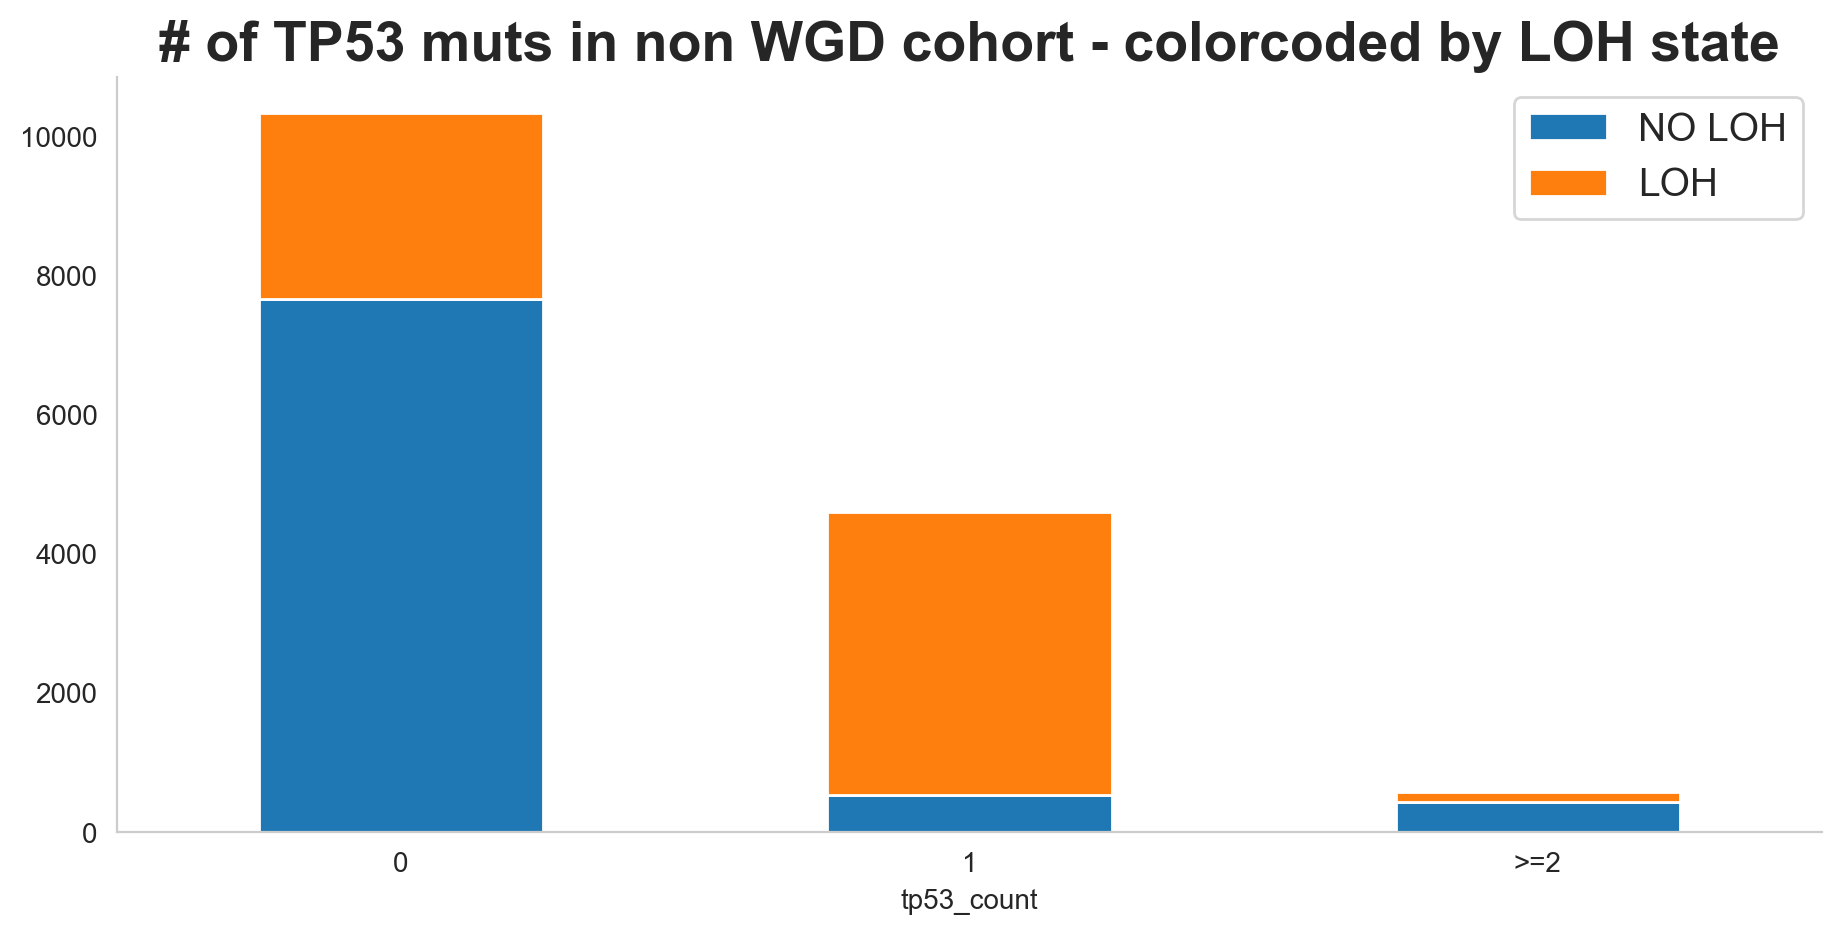

In [111]:
# First we need to groupby our cohort_wgd file to have the size of the different groups
loh_tp53count = pd.DataFrame(master[['tp53_count', 'tp53_loh_status']].groupby(['tp53_count', 'tp53_loh_status']).size()).unstack()
loh_tp53count = loh_tp53count.fillna(0)
loh_tp53count.columns=['NO LOH', 'LOH']
loh_tp53count.loc['>=2'] = [loh_tp53count['NO LOH'][2:].sum(),loh_tp53count['LOH'][2:].sum()]
loh_tp53count = loh_tp53count.drop([2,3,4,5],axis=0)
display(loh_tp53count)

sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = loh_tp53count.plot(kind = 'bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1','>=2'], rotation=0)
ax.legend(['NO LOH', 'LOH'], fontsize=14)
ax.set_title('# of TP53 muts in non WGD cohort - colorcoded by LOH state',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

,CNLOH,LOSS,HOMDEL,NO LOH
tp53_count,,,,
0,144.0,2431.0,96.0,7662.0
1,692.0,3346.0,36.0,530.0
>=2,23.0,119.0,7.0,429.0


,AMP,AMP (BALANCED),CNLOH,CNLOH & GAIN,DIPLOID,GAIN,HETLOSS,HOMDEL,TETRAPLOID,LOSS,NO LOH
tp53_count,,,,,,,,,,,
0,10.0,2.0,144.0,10.0,7385.0,233.0,2431.0,96.0,32.0,2431.0,7662.0
1,1.0,0.0,692.0,35.0,496.0,33.0,3346.0,36.0,0.0,3346.0,530.0
>=2,0.0,1.0,23.0,1.0,411.0,15.0,119.0,7.0,2.0,119.0,429.0


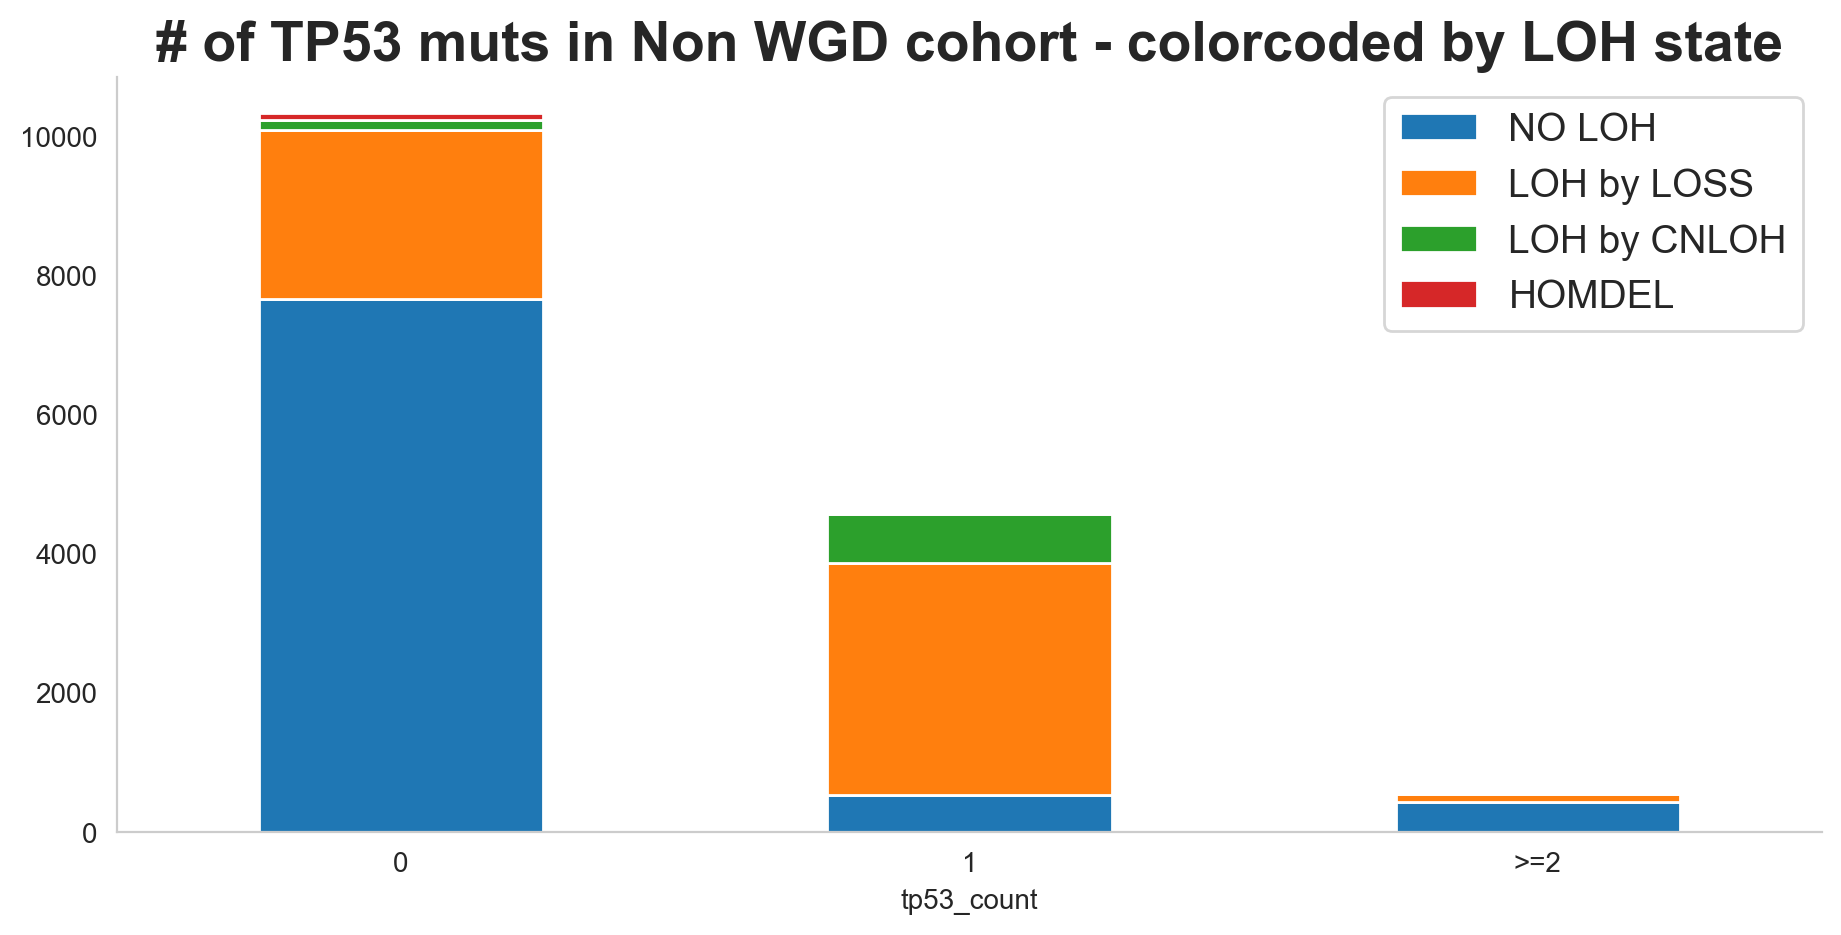

In [113]:
loh_tp53count = pd.DataFrame(master[['tp53_count', 'tp53_cn_state']].groupby(['tp53_count', 'tp53_cn_state']).size()).unstack()
loh_tp53count.columns = ['AMP', 'AMP (BALANCED)', 'CNLOH', 'CNLOH & GAIN', 'DIPLOID', 'GAIN', 'HETLOSS', 'HOMDEL', 'TETRAPLOID']
loh_tp53count = loh_tp53count.fillna(0)

loh_tp53count['CNLOH'] = loh_tp53count[['CNLOH', 'CNLOH & GAIN']].sum(axis=1)
loh_tp53count['LOSS'] = loh_tp53count[['HETLOSS']].sum(axis=1)
loh_tp53count['HOMDEL'] = loh_tp53count[['HOMDEL']].sum(axis=1)
loh_tp53count['NO LOH'] = loh_tp53count[['AMP', 'AMP (BALANCED)', 'DIPLOID', 'GAIN', 'TETRAPLOID']].sum(axis=1)
loh_tp53count.loc['>=2'] = loh_tp53count[2:].sum()
loh_tp53count = loh_tp53count.drop([2,3,4,5],axis=0)

display(loh_tp53count[['CNLOH', 'LOSS', 'HOMDEL', 'NO LOH']])


sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = loh_tp53count[[ 'NO LOH','LOSS', 'CNLOH', 'HOMDEL']].plot(kind = 'bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1','>=2'], rotation=0)
ax.legend(['NO LOH', 'LOH by LOSS', 'LOH by CNLOH', 'HOMDEL'], fontsize=14)
ax.set_title('# of TP53 muts in Non WGD cohort - colorcoded by LOH state',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

loh_tp53count

In [105]:
get_groupby(master[master['tp53_loh_status'] == True], 'tp53_cn_state', 'count')

,count
tp53_cn_state,
CNLOH,813
CNLOH & GAIN,46
HETLOSS,5896
HOMDEL,139


In [107]:
get_groupby(master, 'tp53_cn_state', 'count')

,count
tp53_cn_state,
AMP,11
AMP (BALANCED),3
CNLOH,813
CNLOH & GAIN,46
DIPLOID,8292
GAIN,281
HETLOSS,5896
HOMDEL,139
TETRAPLOID,34


# Recompute Cancer and Metrics Panels
For that we use the scripts:
* *mskimpact_tp53_exploration/analysis/exploratory_analysis/cancer_analysis/cancer_panel.ipynb*
* *mskimpact_tp53_exploration/analysis/exploratory_analysis/metrics_analysis/metrics_panel.ipynb*

The panels are stored in:
*
*

In [72]:
get_groupby(master, 'tp53_lcn', 'count').sort_values(by='count', ascending=False)

,count
tp53_lcn,
1.0,10011
0.0,7761
2.0,69
3.0,5


In [80]:
set(list(master[master['tp53_lcn'] == 0]['tp53_cn_state']))

{'AMP (LOH)', 'CNLOH', 'CNLOH & GAIN', 'HETLOSS', 'HOMDEL'}